In [3]:
!git commit -m "changes"

[master ace7709] changes
 2 files changed, 796 insertions(+), 383 deletions(-)


In [3]:
import random
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
import seaborn as sns
import random
from PIL import Image
from sklearn.utils import class_weight
from keras.layers import Reshape
import keras.backend as K
import math

Using TensorFlow backend.


In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1642208707185270908, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 244842496
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8342452556131200460
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [5]:
# mod = get_model()
# mod.summary()

In [6]:
with open('vgg16-landmark-predictions-stage2.pckl','rb') as file:
    stage2_train_pred,stage2_test_pred,historys,stage_train_scores,stage_test_scores = pickle.load(file)

In [5]:
# mod.summary()

In [34]:
cnn_base = VGG16(input_shape=(224,224,3),include_top=False, weights='imagenet')

for layer in cnn_base.layers:
    layer.trainable = False

x = cnn_base.get_layer('block5_pool').output
x = Conv2D(512, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(4, 4))(x)
x = BatchNormalization()(x)
# x = Conv2D(128, kernel_size=(3, 3), padding="same")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(2, kernel_size=(1, 1), padding="same")(x)
x = Reshape((2,),name='localization_output')(x)

model = Model(inputs=cnn_base.input, outputs=x)
model.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy'])
initial_weights = model.get_weights()

In [21]:
#mod.save_weights("vgg16-landmarks-localization.hd5")
train_pred = []
test_pred = []

train_scores = []
test_scores = []

history_record = []

In [10]:
def process_image_keypoints(img,rectangle_points):
    desired_size = 224

    old_size = img.shape
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format
    im = cv2.resize(img, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    
    #print("rectangle",rectangle_points)
    a,b = rectangle_points
    a = a*ratio
    b = b*ratio
    a = a+left
    b = b+top
    return new_im,[a,b],[ratio,left,top]

In [11]:
def transform_images_landmarks(images,landmarks):
    
    image_set = [[],[],[],[],[],[],[],[],[],[],[]]
    landmark_set = [[],[],[],[],[],[],[],[],[],[],[]]
    correction_set = [[],[],[],[],[],[],[],[],[],[],[]]
    for imge,landmark in zip(images,landmarks):
        try:
            for i in range(11):
                a,b = landmark[i*2],landmark[i*2+1]
                rn_numx = 30 + 30*random.random()
                rn_numy = 30 + 30*random.random()
                xmin,ymin,xmax,ymax = a - rn_numx,b - rn_numy,a + (90-rn_numx),b + (90-rn_numy) 
                if xmin<0:
                    xmin = 0
                if ymin<0:
                    ymin = 0
                sub_img = imge[int(ymin):int(ymax),int(xmin):int(xmax),:]
                sub_img,new_mark,correction = process_image_keypoints(sub_img,[rn_numx,rn_numy])
                image_set[i].append(sub_img)
                landmark_set[i].append(new_mark)
                correction.append(a - rn_numx)
                correction.append(b - rn_numy)
                correction_set[i].append(correction)
        except:
            print("exception")
    return image_set,landmark_set,correction_set

In [12]:
def transform_global_landmark(predictions,corrections):
    landmarks = []
    for pred,corr in zip(predictions,corrections):
        ratio,left,top,xmin,ymin = corr
        x,y = pred
        x = x-left
        y = y-top
        x = x/ratio
        y = y/ratio
        x = x + xmin
        y = y + ymin
        landmarks.append([x,y])
    return landmarks

In [4]:
# with open('data-localize-landmarks'+str(0)+'.pckl','rb') as file:
#         all_images,all_landmarks,all_bboxes,all_image_sizes,test_images,test_landmarks,test_bboxes,test_image_sizes = pickle.load(file)
# image_set,landmark_set = transform_images_landmarks(all_images,all_landmarks)
# test_image_set,test_landmark_set = transform_images_landmarks(test_images,test_landmarks)    

In [8]:
#mod.save_weights("vgg16-landmarks-localization.hd5")
train_pred = []
test_pred = []

train_scores = []
test_scores = []

history_record = []


stage_train_scores = []
stage_test_scores = []

In [123]:
train_pred_all_folds = []
test_pred_all_folds = []
for i in range(5):
    print("Loading file")
    #model.save_weights('model.h5')
    with open('data-localize-landmarks'+str(i)+'.pckl','rb') as file:
        all_images,all_landmarks,all_bboxes,all_image_sizes,all_test_images,test_landmarks,test_bboxes,test_image_sizes = pickle.load(file)
    print("first")
    image_set,landmark_set,_ = transform_images_landmarks(all_images,all_landmarks)
    print("second")
    test_image_set,test_landmark_set,_ = transform_images_landmarks(all_test_images,test_landmarks)
    
    stage2_train_landmarks_temp,stage2_test_landmarks_temp = list(stage2_train_pred[i]),list(stage2_test_pred[i])
    stage2_train_landmarks = []
    stage2_test_landmarks = []
    print("third")
    for j in stage2_train_landmarks_temp:
        temp = []
        for a,b in j:
            temp.append(a)
            temp.append(b)
        if(len(temp)==22):
            stage2_train_landmarks.append(temp)
    print("fourth")
    for j in stage2_test_landmarks_temp:
        temp = []
        for a,b in j:
            temp.append(a)
            temp.append(b)
        if(len(temp)==22):
            stage2_test_landmarks.append(temp)
    print("fifth")
    stage_train_images,stage_train_landmarks,stage_train_corrections = transform_images_landmarks(all_images,stage2_train_landmarks)
    print("sixth")
    stage_test_images,stage_test_landmarks,stage_test_corrections = transform_images_landmarks(all_test_images,stage2_test_landmarks)
    
    train_pred_fold = []
    test_pred_fold = []
    print("loaded")
    for j in range(11):
        print(j)
        try:
            with open('landmarks_localization_vgg16_stage3'+str(i)+str(j)+'.hd5','rb') as f:
                model_weights = pickle.load(f)
        except:
            print("setting initial weights")
            model_weights = initial_weights
        model.set_weights(model_weights)
        model.fit(x=np.array(image_set[j]),y=np.array(landmark_set[j]),batch_size=10,epochs=20,validation_data=(np.array(test_image_set[j]),np.array(test_landmark_set[j])))
        
        train_score = model.evaluate(x=np.array(image_set[j]),y=np.array(landmark_set[j]),batch_size=50)
        test_score = model.evaluate(x=np.array(test_image_set[j]),y=np.array(test_landmark_set[j]),batch_size=50)
        
        train_predictions = model.predict(x=np.array(stage_train_images[j]),batch_size=50)
        test_predictions = model.predict(x=np.array(stage_test_images[j]),batch_size=50)

        train_predictions = transform_global_landmark(train_predictions,stage_train_corrections[j])
        test_predictions = transform_global_landmark(test_predictions,stage_test_corrections[j])
        
        train_pred_fold.append(train_predictions)
        test_pred_fold.append(test_predictions)
            
        try:
            with open('landmarks_localization_vgg16_stage3'+str(i)+str(j)+'.hd5','wb') as f:
                pickle.dump(model.get_weights(),f)
        except Exception as ex:
            print("Could not write",ex)        
    train_pred_all_folds.append(train_pred_fold)
    test_pred_all_folds.append(test_pred_fold)

Loading file
first
second
third
fourth
fifth
sixth
loaded
0
Train on 906 samples, validate on 76 samples
Epoch 1/20
906/906 [==============================] - 14s 16ms/step - loss: 12769.5300 - acc: 0.6060 - val_loss: 12361.3689 - val_acc: 0.7368
Epoch 2/20
906/906 [==============================] - 14s 16ms/step - loss: 9985.4288 - acc: 0.7671 - val_loss: 7117.4344 - val_acc: 0.7763
Epoch 3/20
906/906 [==============================] - 14s 16ms/step - loss: 2902.0334 - acc: 0.8102 - val_loss: 1178.6551 - val_acc: 0.7895
Epoch 4/20
906/906 [==============================] - 14s 16ms/step - loss: 580.3630 - acc: 0.8068 - val_loss: 420.1439 - val_acc: 0.7895
Epoch 5/20
906/906 [==============================] - 14s 16ms/step - loss: 302.9979 - acc: 0.8355 - val_loss: 351.5075 - val_acc: 0.7895
Epoch 6/20
906/906 [==============================] - 14s 16ms/step - loss: 161.7796 - acc: 0.8720 - val_loss: 312.4418 - val_acc: 0.8158
Epoch 7/20
906/906 [==============================] - 14s 1

Epoch 13/20
906/906 [==============================] - 14s 16ms/step - loss: 70.2638 - acc: 0.8918 - val_loss: 119.7020 - val_acc: 0.8289
Epoch 14/20
906/906 [==============================] - 14s 16ms/step - loss: 64.3249 - acc: 0.9095 - val_loss: 120.6925 - val_acc: 0.7895
Epoch 15/20
906/906 [==============================] - 14s 16ms/step - loss: 64.1397 - acc: 0.8797 - val_loss: 111.1859 - val_acc: 0.8553
Epoch 16/20
906/906 [==============================] - 14s 16ms/step - loss: 63.9711 - acc: 0.9084 - val_loss: 121.6135 - val_acc: 0.8158
Epoch 17/20
906/906 [==============================] - 14s 16ms/step - loss: 67.7866 - acc: 0.8951 - val_loss: 121.3310 - val_acc: 0.8026
Epoch 18/20
906/906 [==============================] - 14s 16ms/step - loss: 79.5632 - acc: 0.9029 - val_loss: 121.3473 - val_acc: 0.8421
Epoch 19/20
906/906 [==============================] - 14s 16ms/step - loss: 66.7819 - acc: 0.9018 - val_loss: 123.0527 - val_acc: 0.8421
Epoch 20/20
76/76 [===============

Epoch 9/20
906/906 [==============================] - 14s 16ms/step - loss: 76.4194 - acc: 0.8885 - val_loss: 181.8489 - val_acc: 0.8553
Epoch 10/20
906/906 [==============================] - 14s 16ms/step - loss: 84.0711 - acc: 0.8499 - val_loss: 171.8524 - val_acc: 0.8289
Epoch 11/20
906/906 [==============================] - 14s 16ms/step - loss: 79.5327 - acc: 0.8775 - val_loss: 169.6376 - val_acc: 0.8421
Epoch 12/20
906/906 [==============================] - 14s 16ms/step - loss: 75.6038 - acc: 0.8863 - val_loss: 160.1582 - val_acc: 0.8289
Epoch 13/20
906/906 [==============================] - 14s 16ms/step - loss: 68.1908 - acc: 0.8852 - val_loss: 171.0525 - val_acc: 0.8289
Epoch 14/20
906/906 [==============================] - 14s 16ms/step - loss: 72.2240 - acc: 0.8565 - val_loss: 167.6003 - val_acc: 0.8026
Epoch 15/20
906/906 [==============================] - 14s 16ms/step - loss: 60.1691 - acc: 0.8742 - val_loss: 165.7050 - val_acc: 0.8289
Epoch 16/20
906/906 [==============

76/76 [==============================] - 1s 11ms/step
3
Train on 906 samples, validate on 76 samples
Epoch 1/20
906/906 [==============================] - 14s 16ms/step - loss: 12365.0247 - acc: 0.7219 - val_loss: 10745.1196 - val_acc: 0.7500
Epoch 2/20
906/906 [==============================] - 14s 16ms/step - loss: 6761.9912 - acc: 0.8179 - val_loss: 2879.5583 - val_acc: 0.7632
Epoch 3/20
906/906 [==============================] - 14s 16ms/step - loss: 958.3336 - acc: 0.7925 - val_loss: 286.3724 - val_acc: 0.7763
Epoch 4/20
906/906 [==============================] - 14s 16ms/step - loss: 372.9181 - acc: 0.8510 - val_loss: 195.2670 - val_acc: 0.7763
Epoch 5/20
906/906 [==============================] - 14s 16ms/step - loss: 167.8016 - acc: 0.8355 - val_loss: 182.8903 - val_acc: 0.8158
Epoch 6/20
906/906 [==============================] - 14s 16ms/step - loss: 104.2825 - acc: 0.8675 - val_loss: 183.0484 - val_acc: 0.7763
Epoch 7/20
906/906 [==============================] - 14s 16ms/st

Epoch 17/20
906/906 [==============================] - 14s 16ms/step - loss: 70.7659 - acc: 0.8720 - val_loss: 126.2271 - val_acc: 0.8026
Epoch 18/20
906/906 [==============================] - 14s 16ms/step - loss: 66.5143 - acc: 0.8918 - val_loss: 123.7222 - val_acc: 0.8684
Epoch 19/20
906/906 [==============================] - 14s 16ms/step - loss: 62.1419 - acc: 0.8940 - val_loss: 128.3487 - val_acc: 0.8684
Epoch 20/20
76/76 [==============================] - 1s 11ms/step
6
setting initial weights
Train on 906 samples, validate on 76 samples
Epoch 1/20
906/906 [==============================] - 14s 16ms/step - loss: 12270.0915 - acc: 0.7241 - val_loss: 10833.1309 - val_acc: 0.7763
Epoch 2/20
906/906 [==============================] - 14s 16ms/step - loss: 6344.1059 - acc: 0.8267 - val_loss: 2921.9701 - val_acc: 0.8421
Epoch 3/20
906/906 [==============================] - 14s 16ms/step - loss: 813.6388 - acc: 0.8146 - val_loss: 241.5661 - val_acc: 0.8289
Epoch 4/20
906/906 [=========

Epoch 7/20
906/906 [==============================] - 14s 15ms/step - loss: 93.9532 - acc: 0.8775 - val_loss: 265.7867 - val_acc: 0.7105
Epoch 8/20
906/906 [==============================] - 14s 15ms/step - loss: 96.9951 - acc: 0.9018 - val_loss: 263.3048 - val_acc: 0.7105
Epoch 9/20
906/906 [==============================] - 14s 15ms/step - loss: 87.7227 - acc: 0.9040 - val_loss: 264.2274 - val_acc: 0.7105
Epoch 10/20
906/906 [==============================] - 14s 15ms/step - loss: 84.9680 - acc: 0.8675 - val_loss: 277.5726 - val_acc: 0.6974
Epoch 11/20
906/906 [==============================] - 14s 15ms/step - loss: 87.7224 - acc: 0.8709 - val_loss: 269.1292 - val_acc: 0.7237
Epoch 12/20
906/906 [==============================] - 14s 15ms/step - loss: 78.8076 - acc: 0.8786 - val_loss: 269.5418 - val_acc: 0.6974
Epoch 13/20
906/906 [==============================] - 14s 15ms/step - loss: 74.4066 - acc: 0.8918 - val_loss: 269.6032 - val_acc: 0.6842
Epoch 14/20
906/906 [================

Epoch 19/20
906/906 [==============================] - 14s 15ms/step - loss: 72.1906 - acc: 0.8764 - val_loss: 124.6214 - val_acc: 0.8947
Epoch 20/20
76/76 [==============================] - 1s 10ms/step
6
setting initial weights
Train on 906 samples, validate on 76 samples
Epoch 1/20
906/906 [==============================] - 14s 15ms/step - loss: 12372.9064 - acc: 0.6556 - val_loss: 10843.2403 - val_acc: 0.8158
Epoch 2/20
906/906 [==============================] - 14s 15ms/step - loss: 6420.1610 - acc: 0.8344 - val_loss: 1834.6012 - val_acc: 0.8158
Epoch 3/20
906/906 [==============================] - 14s 15ms/step - loss: 786.5827 - acc: 0.8035 - val_loss: 336.6938 - val_acc: 0.7368
Epoch 4/20
906/906 [==============================] - 14s 15ms/step - loss: 397.2677 - acc: 0.8256 - val_loss: 205.6173 - val_acc: 0.7895
Epoch 5/20
906/906 [==============================] - 14s 15ms/step - loss: 172.0070 - acc: 0.8411 - val_loss: 131.3492 - val_acc: 0.8421
Epoch 6/20
906/906 [=========

909/909 [==============================] - 14s 15ms/step - loss: 84.7845 - acc: 0.8669 - val_loss: 320.6282 - val_acc: 0.6933
Epoch 10/20
909/909 [==============================] - 14s 15ms/step - loss: 89.8399 - acc: 0.8636 - val_loss: 318.9005 - val_acc: 0.6800
Epoch 11/20
909/909 [==============================] - 14s 15ms/step - loss: 83.2037 - acc: 0.8713 - val_loss: 329.1265 - val_acc: 0.6667
Epoch 12/20
909/909 [==============================] - 14s 15ms/step - loss: 79.3496 - acc: 0.8724 - val_loss: 328.5730 - val_acc: 0.6400
Epoch 13/20
909/909 [==============================] - 14s 15ms/step - loss: 79.2755 - acc: 0.8680 - val_loss: 318.8983 - val_acc: 0.6667
Epoch 14/20
909/909 [==============================] - 14s 15ms/step - loss: 77.7372 - acc: 0.8680 - val_loss: 327.0589 - val_acc: 0.6667
Epoch 15/20
909/909 [==============================] - 14s 15ms/step - loss: 76.3211 - acc: 0.8680 - val_loss: 320.9588 - val_acc: 0.7067
Epoch 16/20
909/909 [=========================

75/75 [==============================] - 1s 10ms/step
6
setting initial weights
Train on 909 samples, validate on 75 samples
Epoch 1/20
909/909 [==============================] - 14s 15ms/step - loss: 12347.5299 - acc: 0.7096 - val_loss: 10579.0474 - val_acc: 0.8533
Epoch 2/20
909/909 [==============================] - 14s 15ms/step - loss: 6765.1805 - acc: 0.8614 - val_loss: 2736.2607 - val_acc: 0.8400
Epoch 3/20
909/909 [==============================] - 14s 15ms/step - loss: 895.6468 - acc: 0.8251 - val_loss: 258.9467 - val_acc: 0.8400
Epoch 4/20
909/909 [==============================] - 14s 15ms/step - loss: 383.8217 - acc: 0.8383 - val_loss: 222.1407 - val_acc: 0.8533
Epoch 5/20
909/909 [==============================] - 14s 15ms/step - loss: 156.0719 - acc: 0.8812 - val_loss: 136.9219 - val_acc: 0.8267
Epoch 6/20
909/909 [==============================] - 14s 15ms/step - loss: 106.2913 - acc: 0.9043 - val_loss: 127.8083 - val_acc: 0.8933
Epoch 7/20
909/909 [=====================

909/909 [==============================] - 14s 16ms/step - loss: 85.5949 - acc: 0.8647 - val_loss: 286.5471 - val_acc: 0.6533
Epoch 12/20
909/909 [==============================] - 14s 16ms/step - loss: 75.9606 - acc: 0.8988 - val_loss: 298.6615 - val_acc: 0.6800
Epoch 13/20
909/909 [==============================] - 14s 16ms/step - loss: 74.8332 - acc: 0.8845 - val_loss: 293.9538 - val_acc: 0.6667
Epoch 14/20
909/909 [==============================] - 14s 16ms/step - loss: 80.0908 - acc: 0.8845 - val_loss: 290.7356 - val_acc: 0.6667
Epoch 15/20
909/909 [==============================] - 14s 16ms/step - loss: 81.4250 - acc: 0.8889 - val_loss: 282.9586 - val_acc: 0.6667
Epoch 16/20
909/909 [==============================] - 14s 16ms/step - loss: 80.0519 - acc: 0.9065 - val_loss: 283.0641 - val_acc: 0.6800
Epoch 17/20
909/909 [==============================] - 14s 16ms/step - loss: 87.5703 - acc: 0.8823 - val_loss: 284.1422 - val_acc: 0.6800
Epoch 18/20
909/909 [=========================

909/909 [==============================] - 14s 16ms/step - loss: 12363.7600 - acc: 0.7019 - val_loss: 10731.2210 - val_acc: 0.8133
Epoch 2/20
909/909 [==============================] - 14s 16ms/step - loss: 6309.3334 - acc: 0.8328 - val_loss: 2610.0406 - val_acc: 0.8800
Epoch 3/20
909/909 [==============================] - 14s 16ms/step - loss: 824.2629 - acc: 0.8405 - val_loss: 280.0392 - val_acc: 0.8667
Epoch 4/20
909/909 [==============================] - 14s 16ms/step - loss: 394.0601 - acc: 0.8207 - val_loss: 189.5291 - val_acc: 0.8933
Epoch 5/20
909/909 [==============================] - 14s 16ms/step - loss: 161.8135 - acc: 0.8779 - val_loss: 156.3340 - val_acc: 0.8933
Epoch 6/20
909/909 [==============================] - 14s 16ms/step - loss: 98.8244 - acc: 0.8658 - val_loss: 151.4924 - val_acc: 0.9200
Epoch 7/20
909/909 [==============================] - 14s 16ms/step - loss: 83.2752 - acc: 0.8911 - val_loss: 150.7052 - val_acc: 0.8667
Epoch 8/20
909/909 [=====================

Epoch 18/20
909/909 [==============================] - 14s 16ms/step - loss: 68.2152 - acc: 0.8977 - val_loss: 201.4268 - val_acc: 0.7867
Epoch 19/20
909/909 [==============================] - 14s 16ms/step - loss: 72.6826 - acc: 0.8922 - val_loss: 199.5044 - val_acc: 0.7733
Epoch 20/20
75/75 [==============================] - 1s 11ms/step
9
setting initial weights
Train on 909 samples, validate on 75 samples
Epoch 1/20
909/909 [==============================] - 14s 16ms/step - loss: 12339.6107 - acc: 0.6843 - val_loss: 10595.0982 - val_acc: 0.8000
Epoch 2/20
909/909 [==============================] - 14s 16ms/step - loss: 6401.9063 - acc: 0.8020 - val_loss: 1685.8618 - val_acc: 0.8400
Epoch 3/20
909/909 [==============================] - 14s 16ms/step - loss: 858.4419 - acc: 0.8306 - val_loss: 299.9418 - val_acc: 0.8133
Epoch 4/20
909/909 [==============================] - 14s 16ms/step - loss: 347.7850 - acc: 0.8273 - val_loss: 222.5385 - val_acc: 0.8133
Epoch 5/20
909/909 [=========

In [ ]:
# with open('data-localize-landmarks'+str(0)+'.pckl','rb') as file:
#         all_images,all_landmarks,all_bboxes,all_image_sizes,test_images,test_landmarks,test_bboxes,test_image_sizes = pickle.load(file)
# image_set,landmark_set = transform_images_landmarks(all_images,all_landmarks)
# test_image_set,test_landmark_set = transform_images_landmarks(test_images,test_landmarks)    

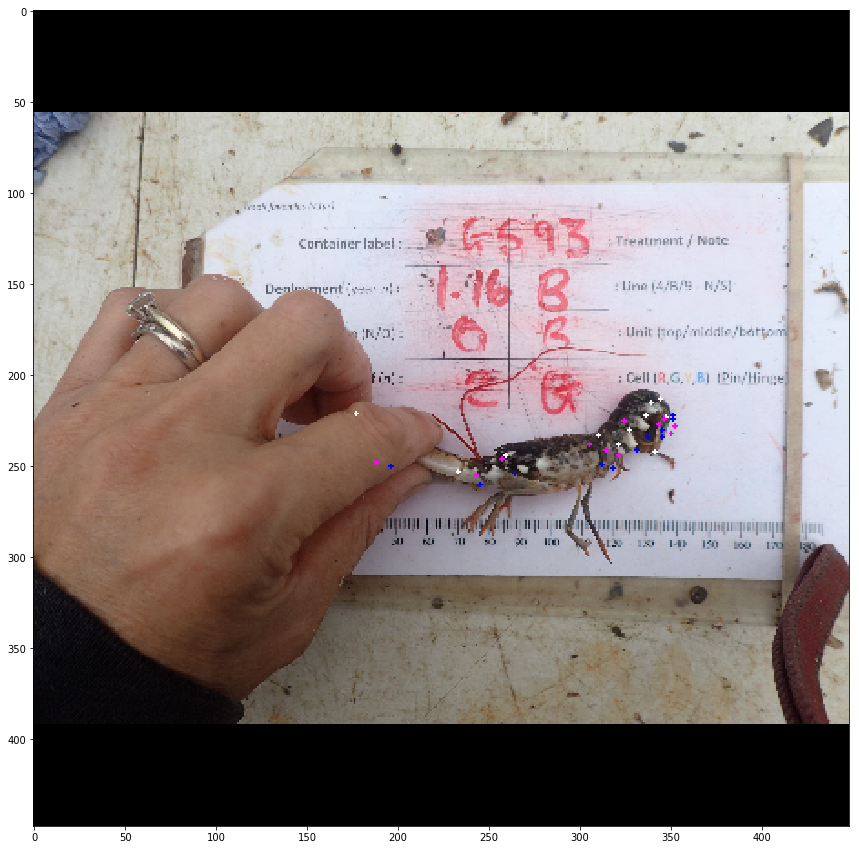

In [135]:
idx = 0
for set_num in range(11):
    img = cv2.circle(all_test_images[idx],(int(stage2_test_landmarks[idx][2*set_num]),int(stage2_test_landmarks[idx][2*set_num+1])), 1, (0,0,255), -1)
    img = cv2.circle(all_test_images[idx],(int(test_pred_all_folds[4][set_num][idx][0]),int(test_pred_all_folds[4][set_num][idx][1])), 1, (255,0,255), -1)
    img = cv2.circle(all_test_images[idx],(int(test_landmarks[idx][2*set_num]),int(test_landmarks[idx][2*set_num+1])), 1, (255,255,255), -1)
#img = cv2.circle(stage_train_images[set_num][idx],(int(x),int(y)), 1, (255,0,255), -1)
plt.figure(figsize=(15,15))
plt.imshow(img)

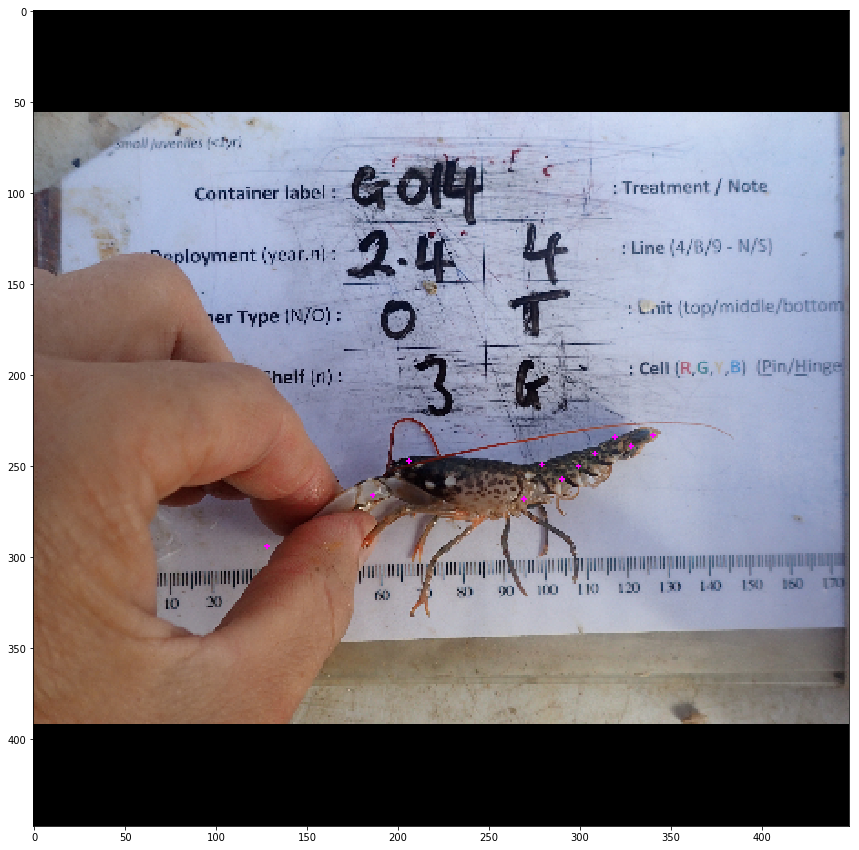

In [130]:
idx = 301
for set_num in range(11):
    #img = cv2.circle(all_images[idx],(int(stage2_train_landmarks[idx][2*set_num]),int(stage2_train_landmarks[idx][2*set_num+1])), 1, (0,0,255), -1)
    img = cv2.circle(all_images[idx],(int(train_pred_all_folds[4][set_num][idx][0]),int(train_pred_all_folds[4][set_num][idx][1])), 1, (255,0,255), -1)
    #img = cv2.circle(all_images[idx],(int(all_landmarks[idx][2*set_num]),int(all_landmarks[idx][2*set_num+1])), 1, (255,255,255), -1)
#img = cv2.circle(stage_train_images[set_num][idx],(int(x),int(y)), 1, (255,0,255), -1)
plt.figure(figsize=(15,15))
plt.imshow(img)

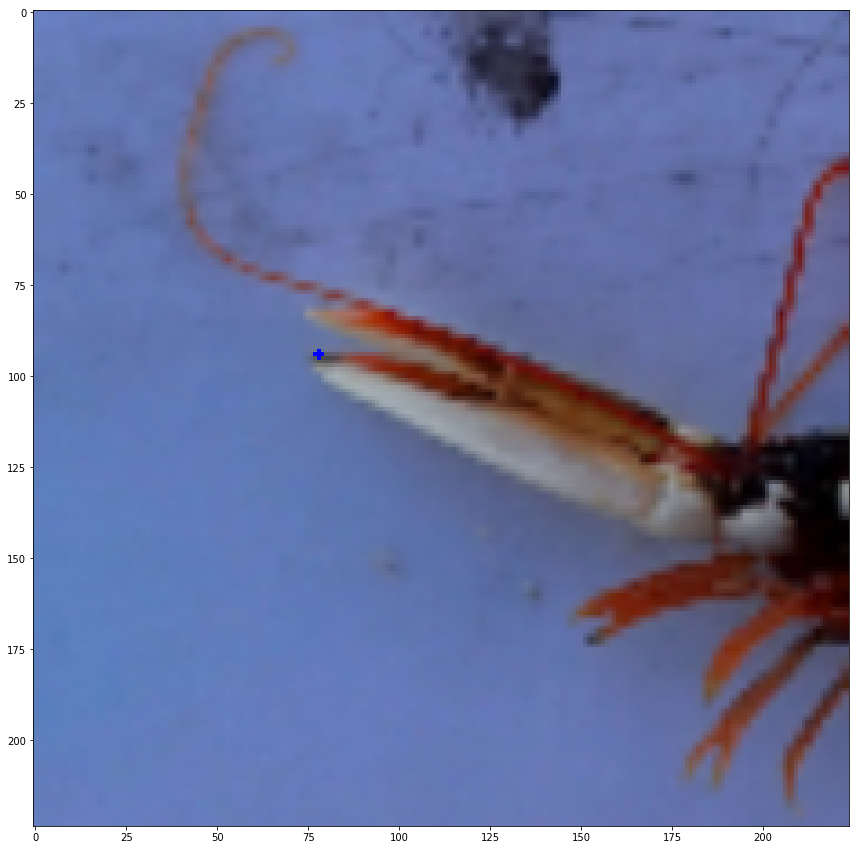

In [93]:
idx = 30
set_num = 0
#[[x,y]] = model.predict(np.expand_dims(test_image_set[0][idx],0))
img = cv2.circle(test_image_set[set_num][idx],(int(test_landmark_set[set_num][idx][0]),int(test_landmark_set[set_num][idx][1])), 1, (0,0,255), -1)
#img = cv2.circle(test_image_set[set_num][idx],(int(x),int(y)), 1, (255,0,255), -1)
plt.figure(figsize=(15,15))
plt.imshow(img)

In [1]:
historys = []
for hist in history_record:
    historys.append(hist.history)
    
with open('vgg16-landmark-predictions-stage3.pckl','wb') as file:
    pickle.dump((train_pred_all_folds,test_pred_all_folds,historys,train_scores,test_scores),file)

NameError: name 'history_record' is not defined

In [10]:
with open('vgg16-landmark-predictions-stage2.pckl','rb') as file:
    stage2_train_pred,stage2_test_pred,historys,stage_train_scores,stage_test_scores = pickle.load(file)

In [11]:
with open('vgg16-landmark-predictions-stage3.pckl','rb') as file:
    train_pred_all_folds,test_pred_all_folds,historys,train_scores,test_scores = pickle.load(file)

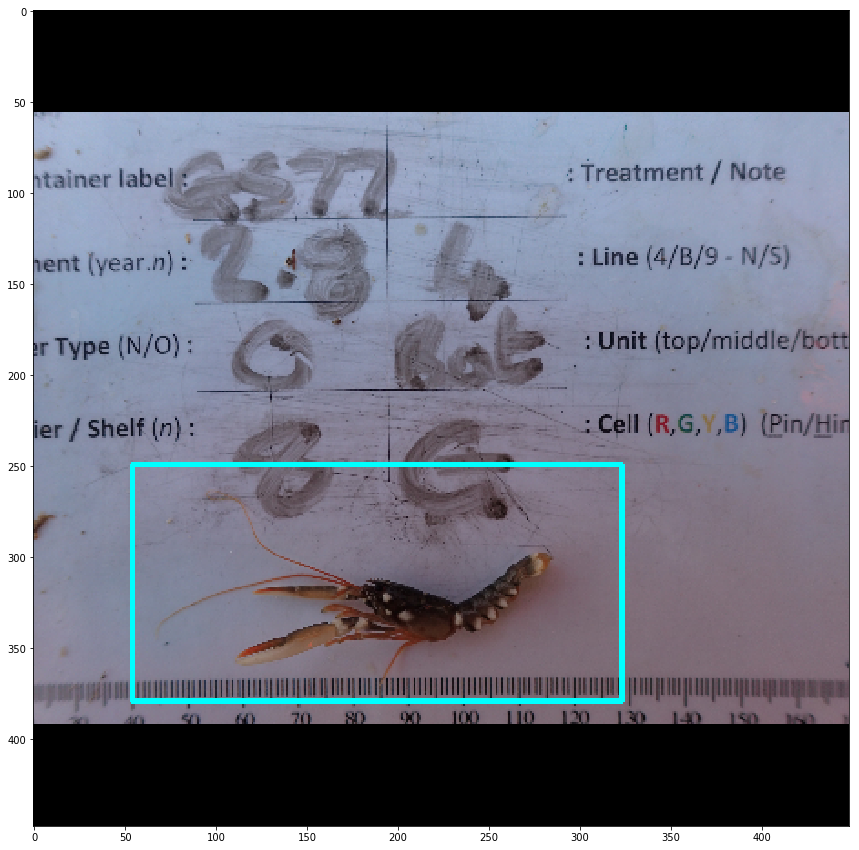

In [98]:
idx = 3
tuples = []
#for i in range(11):
#    tuples.append((all_landmarks[idx][i*2],all_landmarks[idx][i*2+1]))
#for i in range(11):
#    img = cv2.circle(all_images[idx],(int(tuples[i][0]),int(tuples[i][1])), 1, (0,0,255), -1)
    
pt1 = (int(all_bboxes[idx][0]),int(all_bboxes[idx][1]))
pt2 = (int(all_bboxes[idx][2]),int(all_bboxes[idx][3]))
img = cv2.rectangle(all_images[idx],pt1,pt2,(0,255,255),thickness=2)
pil_im = Image.fromarray(img)
plt.figure(figsize=(15,15))
plt.imshow(pil_im)

In [46]:
len(stage2_test_pred[fold_number][0][0])

2

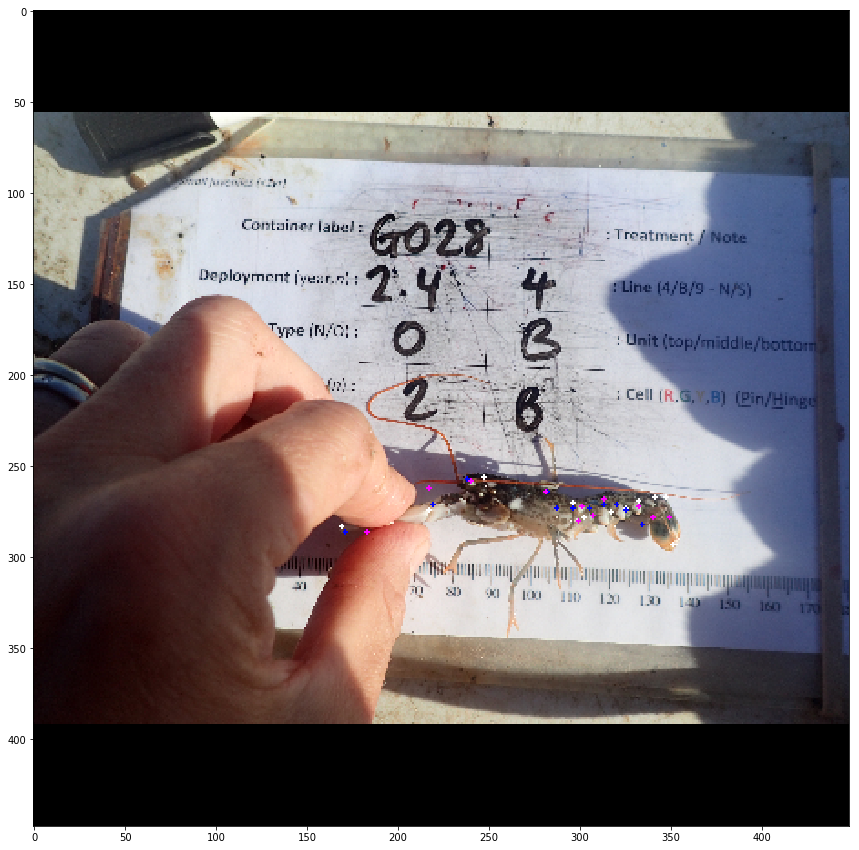

In [48]:
idx = 1
for set_num in range(11):
    img = cv2.circle(all_test_images[idx],(int(stage2_test_pred[fold_number][idx][set_num][0]),int(stage2_test_pred[fold_number][idx][set_num][1])), 1, (0,0,255), -1)
    img = cv2.circle(all_test_images[idx],(int(test_pred_all_folds[fold_number][set_num][idx][0]),int(test_pred_all_folds[fold_number][set_num][idx][1])), 1, (255,0,255), -1)
    img = cv2.circle(all_test_images[idx],(int(test_landmarks[idx][2*set_num]),int(test_landmarks[idx][2*set_num+1])), 1, (255,255,255), -1)
plt.figure(figsize=(15,15))
plt.imshow(img)

In [7]:
def global_localization_error(test_pred,test_landmarks):
    error = 0
    for idx in range(len(test_landmarks)):
        for set_num in range(11):
            predx,predy = test_pred[set_num][idx][0],test_pred[set_num][idx][1]
            x,y  = test_landmarks[idx][2*set_num],test_landmarks[idx][2*set_num+1]
            error = error + math.sqrt((predx-x)**2 + (predy-y)**2)
    return error/(len(test_landmarks)*11)

In [8]:
def global_localization_error_2(test_pred,test_landmarks):
    error = 0
    for idx in range(len(test_landmarks)):
        for set_num in range(11):
            predx,predy = test_pred[idx][set_num][0],test_pred[idx][set_num][1]
            x,y  = test_landmarks[idx][2*set_num],test_landmarks[idx][2*set_num+1]
            error = error + math.sqrt((predx-x)**2 + (predy-y)**2)
    return error/(len(test_landmarks)*11)

In [23]:
#fold_number = 3
mean_error = []
for fold_number in range(5):
    with open('data-localize-landmarks'+str(fold_number)+'.pckl','rb') as file:
            all_images,all_landmarks,all_bboxes,all_image_sizes,all_test_images,test_landmarks,test_bboxes,test_image_sizes = pickle.load(file)
    mean_error.append(global_localization_error(test_pred_all_folds[fold_number],test_landmarks))
print(sum(mean_error)/len(mean_error))

12.650212731490896


In [21]:
mean_error = []
for fold_number in range(5):
    with open('data-localize-landmarks'+str(fold_number)+'.pckl','rb') as file:
        all_images,all_landmarks,all_bboxes,all_image_sizes,all_test_images,test_landmarks,test_bboxes,test_image_sizes = pickle.load(file)
    mean_error.append(global_localization_error_2(stage2_test_pred[fold_number],test_landmarks))
print(sum(mean_error)/len(mean_error))

13.900941068172411


In [24]:
mean_error

[12.558377760105977,
 11.106555652787907,
 11.74708983501351,
 15.961010018761863,
 11.878030390785227]